### Preprocessing Dataset
- Encode categorical dataset
- Handling Imbalanced Churn class

In [30]:
import pandas as pd
import numpy as np
import re

# load dataset
df_train = pd.read_csv("df_development.csv")
df_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### SMOTE algorithm

In [31]:
df_train_2 = df_train.drop(['customerID', 'Churn'], axis=1)

df_encoded = pd.get_dummies(df_train_2)
df_encoded['Churn'] = [0 if item=="No" else 1 for item in df_train['Churn'].tolist()]
#df_encoded.head()

encoded_x = df_encoded.drop(['Churn'], axis=1)
encoded_y = df_encoded['Churn'].tolist()

X_train, X_test, y_train, y_test = train_test_split(encoded_x, encoded_y, test_size=0.3, stratify=encoded_y, random_state=42)

from imblearn.over_sampling import SMOTE
from collections import Counter

print("Before: ", Counter(y_train))

smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

print("After: ", Counter(y_train_sm))

Before:  Counter({0: 3611, 1: 1298})
After:  Counter({0: 3611, 1: 3611})


In [32]:
# build LR with SMOTE
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_sm, y_train_sm)

LogisticRegression(random_state=42, solver='liblinear')

In [33]:
pred = model.predict(X_test)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1548
           1       0.62      0.63      0.62       556

    accuracy                           0.80      2104
   macro avg       0.74      0.74      0.74      2104
weighted avg       0.80      0.80      0.80      2104



### Try without smote ..

In [2]:
# encode using one hot encoding, drop customerID
df_train_1 = df_train.drop(['customerID'], axis=1)

In [3]:
# transform label to 0 and 1

_x = df_train_1.drop(['Churn'], axis=1)
_y = [0 if item=="No" else 1 for item in df_train_1['Churn'].tolist()]

### Modelling

In [4]:
# ml library
from sklearn.linear_model import LogisticRegression

In [5]:
# fit model using  pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

num_col = ["tenure", "SeniorCitizen", "MonthlyCharges", "TotalCharges"]
object_df = _x.drop(num_col, axis=1)
object_col = object_df.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(_x, _y, test_size=0.3, stratify=_y, random_state=42)

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly=2, transform='yeo-johnson'), num_col),
    ('categoric', cat_pipe(encoder='onehot'), object_col),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

modelLogReg = RandomizedSearchCV(pipeline, rsp.logreg_poly_params, cv=4, n_jobs=-1, verbose=1)
modelLogReg.fit(X_train, y_train)

print(modelLogReg.best_params_)
print(modelLogReg.score(X_train, y_train), modelLogReg.best_score_, modelLogReg.score(X_test, y_test))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/home/brata_ari/envme/py37/lib/python3.7/site-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.2s finished
/home/brata_ari/envme/py37/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__C': 0.009741318786968899, 'algo__fit_intercept': False, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': True}
0.8036259930739458 0.8013850616821834 0.80893536121673


### Evaluation

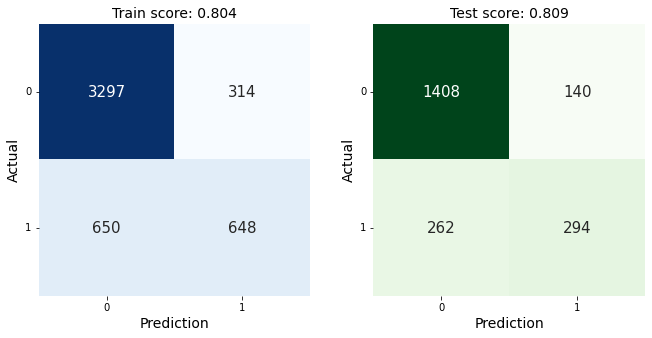

In [6]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve, plot_pr_curve

plot_confusion_matrix(X_train, y_train, X_test, y_test, modelLogReg)

In [7]:
plot_classification_report(X_train, y_train, X_test, y_test, modelLogReg, report=True)

Train report
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3611
           1       0.67      0.50      0.57      1298

    accuracy                           0.80      4909
   macro avg       0.75      0.71      0.72      4909
weighted avg       0.79      0.80      0.79      4909


Test report
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1548
           1       0.68      0.53      0.59       556

    accuracy                           0.81      2104
   macro avg       0.76      0.72      0.73      2104
weighted avg       0.80      0.81      0.80      2104



In [8]:
from sklearn.metrics import roc_auc_score

# predict probabilities
pred_prob = modelLogReg.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob[:,1])
print(auc_score)

0.8503394958451844


Dilihat dari AUC score kita mendapatkan score 85, jika nilai dari AUC kita terlalu kecil maka kita perlu melakukan resampling data.

Disini kita tidak perlu melakukan resampling data, karena business problem kita kedua kelas sama pentingnya baik kelas positif maupun negatif. Jadi, semakin tinggi nilai AUC suatu classifier, semakin baik kemampuannya untuk membedakan antara kelas positif dan negatif.

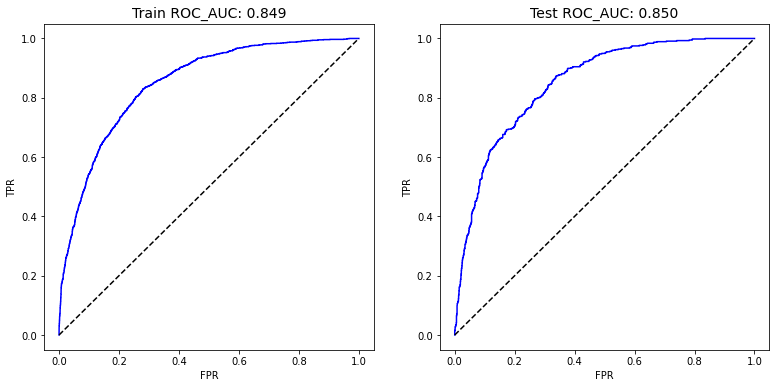

In [9]:
plot_roc_curve(X_train, y_train, X_test, y_test, modelLogReg)

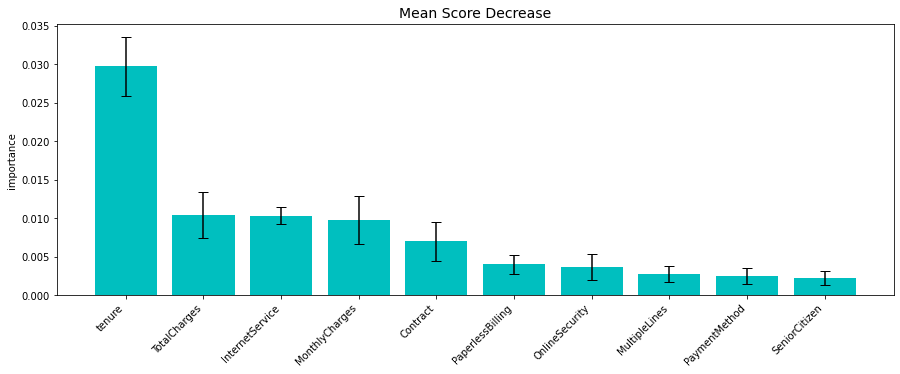

In [10]:
# Feature Importance
df_imp = mean_score_decrease(X_train, y_train, modelLogReg, plot=True, topk=10)

### We decide to choose without SMOTE

In [18]:
import pickle

#pickle.dump(modelLogReg, open("logregChurn.pkl", "wb"))
#pickle.dump(modelLogReg.best_estimator_, open("logreg_smallChurn.pkl", "wb"))

### Predict Unseen Dataset

In [26]:
unseen_df = pd.read_csv("unseen_dataset.csv")
unseen_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4847-QNOKA,Female,0,No,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.90,44.90,Yes
1,5103-MHMHY,Female,0,No,Yes,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Mailed check,45.95,45.95,Yes
2,1455-ESIQH,Male,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,89.10,89.10,Yes
3,8784-CGILN,Female,0,No,No,18,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),99.85,1776.95,Yes
4,9821-POOTN,Male,0,Yes,No,35,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,75.20,2576.20,Yes


In [27]:
actual_churn = [0 if item=="No" else 1 for item in unseen_df['Churn'].tolist()]
unseen_df = unseen_df.drop(["customerID", "Churn"], axis=1)

In [28]:
pred = pd.Series(modelLogReg.predict(unseen_df[unseen_df.columns.tolist()]))
print(pred)

0     1
1     0
2     1
3     1
4     0
5     0
6     1
7     1
8     0
9     1
10    1
11    1
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
dtype: int64


In [29]:
print(classification_report(actual_churn,pred))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.53      0.70        15

    accuracy                           0.77        30
   macro avg       0.84      0.77      0.75        30
weighted avg       0.84      0.77      0.75        30



#### Dari 15 kelas yang Churn, model dapat memprediksi benar sebesar 8 kelas, cukup impresive.